In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import datetime
from datetime import timedelta
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)

In [39]:
def general_plot(x_, y_, x_bounds = None, y_bounds = None, title = None, x_title = None, y_title = None):
    fig, ax = plt.subplots(figsize=(15, 4))

    plt.xticks(rotation=90)
    plt.grid(True)
    
    if title is not None:
        plt.title(title)
    
    if x_title is not None:    
        plt.xlabel(x_title)
        
    if y_title is not None:    
        plt.ylabel(y_title)
    
    if (x_bounds is not None):
        plt.xlim(x_bounds)
               
    if (y_bounds is not None):
        plt.ylim(y_bounds)
    ax.plot(x_,y_, 'bo')
    
    plt.show()

In [40]:
# Useful classes to have easier access to data features
class ColumnsInput:
    barcode = 'ddc_barcode'
    ipcode = 'ddc_ipcode'
    machine = 'ddc_mch_code'
    machine_side = 'ddc_mch_side'
    event = 'ddc_ev_subcode'
    time = 'ddc_ev_timestamp'
    
    
class ColumnsOutput:
    c_machine = 'c_machine' 
    event_delta_time = 'event_delta_time'
    day = 'y-m-day'
    month = 'month'
    status = 'status'

In [41]:
# import starting data, filename path structure is : s3://unitrento/dc_events_timestamp/year=202X/month=XX/day=XX/output.snappy.parquet

df=pd.read_csv("Data/preprocessed_data_2022.csv", low_memory=False)

In [42]:
# Data sample
df[ColumnsInput.time] = pd.to_datetime(df[ColumnsInput.time])
df[ColumnsOutput.status] = "False"
df

,Unnamed: 0,ddc_barcode,ddc_ipcode,ddc_mch_code,ddc_mch_side,ddc_ev_subcode,ddc_ev_timestamp,c_machine,month,y-m-day,status
0,0,9439809283,24453,C504,R,OP_PRESS_STOP_PAUSE_3_STOP,2022-10-10 00:00:00,True,10,22-10-10,False
1,1,9439809363,24453,C504,R,OP_PRESS_STOP_PAUSE_3_STOP,2022-10-10 00:00:00,True,10,22-10-10,False
2,2,9439685760,39336,C203,R,OP_PRESS_STOP_PAUSE_3_START,2022-10-10 00:00:00,True,10,22-10-10,False
3,3,9439713354,18825,C301,R,OP_PRESS_STOP_PAUSE_3_STOP,2022-10-10 00:00:00,True,10,22-10-10,False
4,4,9439779491,42096,C408,L,OP_PRESS_STOP_PAUSE_3_STOP,2022-10-10 00:00:00,True,10,22-10-10,False
5,5,9439702631,36430,C207,L,CURING_OFF_START,2022-10-10 00:00:00,True,10,22-10-10,False
6,6,9439808969,39332,C508,L,CURING_OFF_START,2022-10-10 00:00:00,True,10,22-10-10,False
7,7,9439790422,24177,C505,L,CURING_OFF_START,2022-10-10 00:00:00,True,10,22-10-10,False
8,8,9439818677,25449,C507,R,OP_PRESS_STOP_PAUSE_3_START,2022-10-10 00:00:00,True,10,22-10-10,False
9,9,9439691841,40638,C409,L,UN_FORK_OUT_START,2022-10-10 00:00:00,True,10,22-10-10,False


### Missing values analysis

In [43]:
missing_values = df.isnull().sum() / len(df)
missing_values = missing_values[missing_values>0]
missing_values

Series([], dtype: float64)

There are not missing values in the dataset, so each step is define with event and timestamp without misses

In [44]:
last_indexes = df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['last']).reset_index()
first_indexes = df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg('first').reset_index()
first_last_indexes = df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['first', 'last']).reset_index()
print(len(last_indexes))
print(len(first_indexes))
first_last_indexes

425880
425880


,ddc_barcode,first,last
0,----------,LO_LOADER_IN_PRESS_START,UN_UNLOADER_OUT_STOP
1,9436328592,LO_LOADER_IN_PRESS_START,UN_UNLOADER_OUT_STOP
2,9437340676,LO_LOADER_IN_PRESS_START,UN_FORK_OUT_STOP
3,9437340677,LO_LOADER_IN_PRESS_START,UN_TCR_DOWN_STOP
4,9437342157,LO_LOADER_IN_PRESS_START,UN_FORK_OUT_STOP
5,9437342160,LO_LOADER_IN_PRESS_START,UN_FORK_OUT_STOP
6,9437342161,LO_LOADER_IN_PRESS_START,UN_TCR_DOWN_STOP
7,9437342168,OP_PRESS_MOVEMENT_UP_1_START,UN_FORK_OUT_STOP
8,9437342186,LO_LOADER_IN_PRESS_START,UN_TCR_DOWN_STOP
9,9437342187,LO_LOADER_IN_PRESS_START,UN_FORK_OUT_STOP


### Press analysis
Different stats by press machines

##### Tyre per press' arm during one day

In [45]:
#machines names
machines = df[ColumnsInput.machine].unique()
df_per_day = []
days = []
for day in df[ColumnsOutput.day].unique():
    days.append(str(day))
    df_per_day.append(df[df[ColumnsOutput.day] == day])
    print(day, df[df[ColumnsOutput.day] == day].shape)
for i in range(len(df_per_day)):
    df_per_day[i] = df_per_day[i].groupby([ColumnsInput.machine])[ColumnsInput.barcode].nunique()
    df_per_day[i] = df_per_day[i].reset_index()
    count = 0
    tmp = []
    for mach in machines:
        if mach not in df_per_day[i][ColumnsInput.machine].unique():
            count += 1
            tmp.append({ColumnsInput.machine: mach, ColumnsInput.barcode: 0})
    df_per_day[i] = pd.concat([df_per_day[i], pd.DataFrame(tmp)], ignore_index=True)
    df_per_day[i].sort_values(by=[ColumnsInput.machine], inplace=True)

    print(df_per_day[i].shape)

22-10-10 (525888, 11)
22-10-11 (452484, 11)
22-10-12 (531767, 11)
22-10-13 (483620, 11)
22-10-14 (509784, 11)
22-10-15 (469279, 11)
22-10-16 (541884, 11)
22-10-17 (522291, 11)
22-10-18 (514349, 11)
22-10-19 (336900, 11)
22-10-20 (185868, 11)
22-10-21 (161468, 11)
22-10-22 (512762, 11)
22-10-23 (536665, 11)
22-10-24 (544226, 11)
22-10-25 (350094, 11)
22-10-26 (446388, 11)
22-10-27 (363812, 11)
22-10-28 (495731, 11)
22-10-29 (559651, 11)
22-10-30 (552382, 11)
22-10-31 (546623, 11)
22-11-10 (641693, 11)
22-11-11 (646245, 11)
22-11-12 (713060, 11)
22-11-13 (681667, 11)
22-11-14 (634052, 11)
22-11-15 (549575, 11)
22-11-16 (579017, 11)
22-11-17 (534123, 11)
22-11-18 (626513, 11)
22-11-19 (690822, 11)
22-11-20 (740172, 11)
22-11-21 (730163, 11)
22-11-22 (705702, 11)
22-11-23 (571725, 11)
22-11-24 (676852, 11)
22-11-25 (590840, 11)
22-11-26 (687752, 11)
22-11-27 (704757, 11)
22-11-28 (651402, 11)
22-11-29 (643810, 11)
22-11-30 (643699, 11)
22-12-10 (685804, 11)
22-12-11 (687003, 11)
22-12-12 (

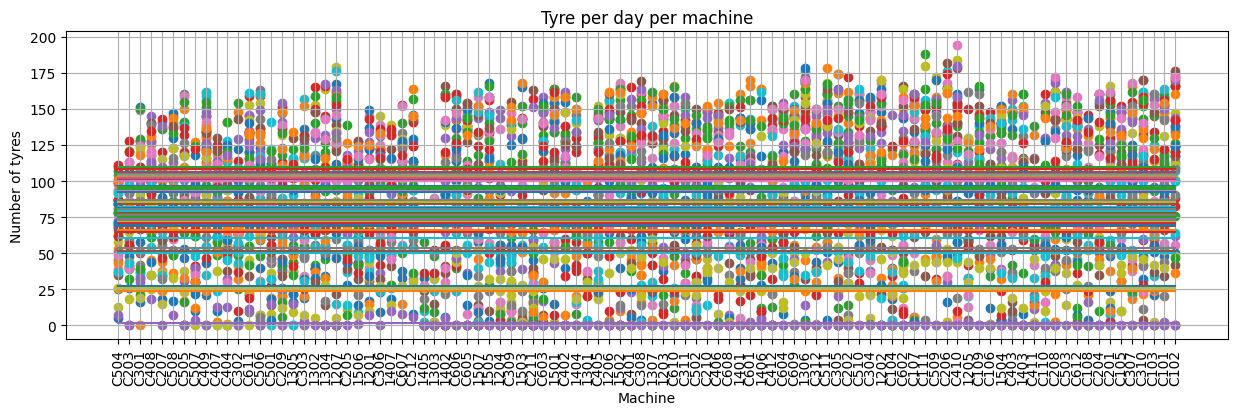

In [46]:
fig, ax = plt.subplots(figsize=(15, 4))
x = machines

for i in range(len(df_per_day)):
    y = df_per_day[i][ColumnsInput.barcode]
    y_mean = np.full(shape = len(x), fill_value = y.mean())
    ax.scatter(x,y,label=days[i])
    ax.plot(x,y_mean)
plt.xticks(rotation=90)
plt.grid(True)
    
plt.title("Tyre per day per machine")
plt.xlabel("Machine")
plt.ylabel("Number of tyres")
#ax.legend()
plt.show()

In [47]:
#get days with peaks of tyres
top_10_days = []
for i in range(len(df_per_day)):
    prod_mean = df_per_day[i][ColumnsInput.barcode].mean()
    if len(top_10_days) < 10:
        top_10_days.append({ColumnsOutput.day: days[i], 'N_tyres_mean': prod_mean,  'index': i})
        top_10_days.sort(key=lambda x: x['N_tyres_mean'], reverse=True)
    else:
        if prod_mean > top_10_days[-1]['N_tyres_mean']:
            top_10_days[-1] = {ColumnsOutput.day: days[i], 'N_tyres_mean': prod_mean, 'index': i}
            top_10_days.sort(key=lambda x: x['N_tyres_mean'], reverse=True)
print(top_10_days)

[{'y-m-day': '22-11-20', 'N_tyres_mean': 109.53061224489795, 'index': 32}, {'y-m-day': '22-11-21', 'N_tyres_mean': 108.0, 'index': 33}, {'y-m-day': '22-12-12', 'N_tyres_mean': 106.20408163265306, 'index': 45}, {'y-m-day': '22-11-12', 'N_tyres_mean': 104.76530612244898, 'index': 24}, {'y-m-day': '22-11-27', 'N_tyres_mean': 104.44897959183673, 'index': 39}, {'y-m-day': '22-11-22', 'N_tyres_mean': 104.13265306122449, 'index': 34}, {'y-m-day': '22-12-18', 'N_tyres_mean': 103.6734693877551, 'index': 51}, {'y-m-day': '22-11-19', 'N_tyres_mean': 102.14285714285714, 'index': 31}, {'y-m-day': '22-12-11', 'N_tyres_mean': 101.83673469387755, 'index': 44}, {'y-m-day': '22-11-26', 'N_tyres_mean': 101.37755102040816, 'index': 38}]


In [48]:
#plot top 10 days
top_10_days_df = []
for day in top_10_days:
    top_10_days_df.append(df_per_day[day['index']])

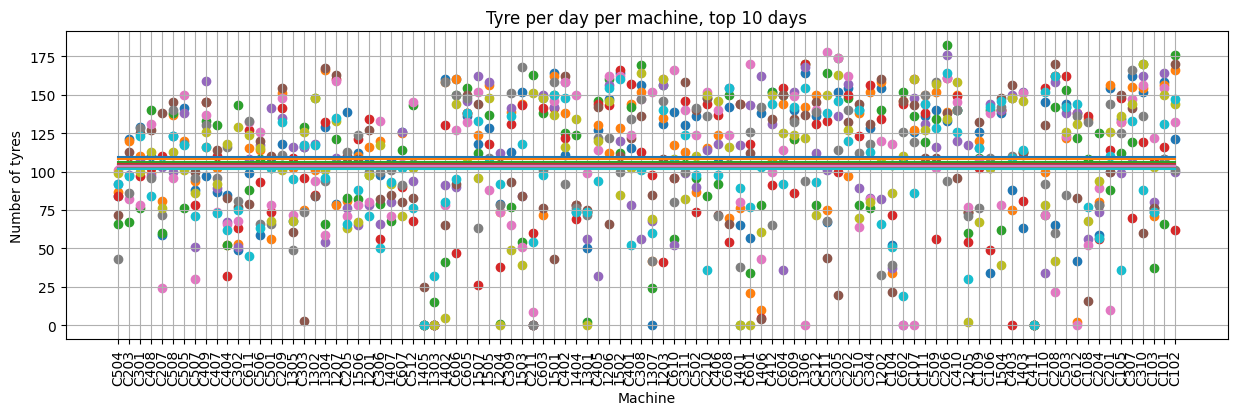

In [49]:
fig, ax = plt.subplots(figsize=(15, 4))
x = machines

for i in range(len(top_10_days_df)):
    y = top_10_days_df[i][ColumnsInput.barcode]
    y_mean = np.full(shape = len(x), fill_value = y.mean())
    ax.scatter(x,y,label=days[i])
    ax.plot(x,y_mean)
plt.xticks(rotation=90)
plt.grid(True)
    
plt.title("Tyre per day per machine, top 10 days")
plt.xlabel("Machine")
plt.ylabel("Number of tyres")
#ax.legend()
plt.show()

In [50]:
top_10_days_df_events = []
for day_ in top_10_days:
    top_10_days_df_events.append(df.loc[df[ColumnsOutput.day] == day_['y-m-day']])

top_10_days_df_concat = pd.concat(top_10_days_df_events, ignore_index=True)
top_10_days_df_concat_events = top_10_days_df_concat.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['first','last']).value_counts()
top_10_days_df_concat_events.head()

first                     last                
LO_LOADER_IN_PRESS_START  UN_FORK_OUT_STOP        46245
                          UN_UNLOADER_OUT_STOP    29665
                          UN_TCR_DOWN_STOP        21683
                          UN_VACUUM_STOP            404
                          CURING_ON_START           362
Name: count, dtype: int64

In [51]:
#fig, ax = plt.subplots(figsize=(15, 4))

In [52]:
#visualize the number of tyre per month
machines = df[ColumnsInput.machine].unique()
df_per_month = []
months = []
for month in df[ColumnsOutput.month].unique():
    months.append(str(month))
    df_per_month.append(df[df[ColumnsOutput.month] == month])
    print(month, df[df[ColumnsOutput.month] == month].shape)
for i in range(len(df_per_month)):
    df_per_month[i] = df_per_month[i].groupby([ColumnsInput.machine])[ColumnsInput.barcode].nunique()
    df_per_month[i] = df_per_month[i].reset_index()
    current_machines = df_per_month[i][ColumnsInput.machine].unique()
    
    tmp = []
    for mach in machines:
        if mach not in current_machines:
            tmp.append({ColumnsInput.machine: mach, ColumnsInput.barcode: 0})
    df_per_month[i] = pd.concat([df_per_month[i], pd.DataFrame(tmp)], ignore_index=True)
    df_per_month[i].sort_values(by=[ColumnsInput.machine], inplace=True)

    print(df_per_month[i].shape)

10 (10143916, 11)
11 (13643641, 11)
12 (6098056, 11)
(98, 2)
(98, 2)
(98, 2)


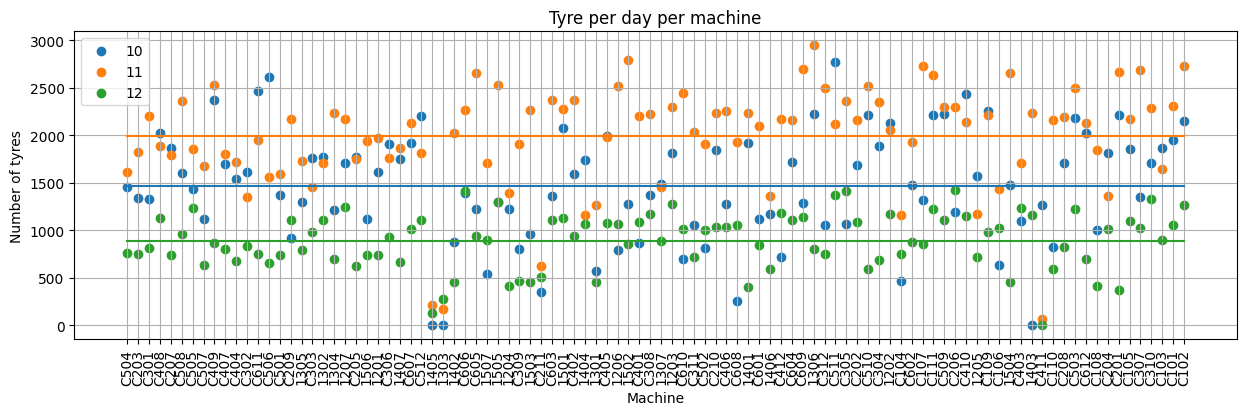

In [53]:
fig, ax = plt.subplots(figsize=(15, 4))
x = machines

for i in range(len(df_per_month)):
    y = df_per_month[i][ColumnsInput.barcode]
    y_mean = np.full(shape = len(x), fill_value = y.mean())
    ax.scatter(x,y,label=months[i])
    ax.plot(x,y_mean)
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()   
plt.title("Tyre per day per machine")
plt.xlabel("Machine")  
plt.ylabel("Number of tyres")

plt.show()

In [54]:
old_vs_new = df.groupby([ColumnsInput.machine, ColumnsOutput.c_machine, ColumnsOutput.day])[ColumnsInput.barcode].nunique().reset_index()
old_vs_new_mean = old_vs_new.groupby([ColumnsInput.machine, ColumnsOutput.c_machine])[ColumnsInput.barcode].mean().reset_index()
old_vs_new_mean = old_vs_new_mean.groupby([ColumnsOutput.c_machine])[ColumnsInput.barcode].mean().reset_index()
old_vs_new_mean

,c_machine,ddc_barcode
0,False,84.332115
1,True,90.990174


In [55]:


tyre_per_machine = df.groupby([ColumnsInput.machine])[ColumnsInput.barcode].nunique()
tyre_per_machine = tyre_per_machine.sort_values().reset_index()
tyre_per_machine

,ddc_mch_code,ddc_barcode
0,C101,344
1,C102,448
2,C511,1325
3,C111,1482
4,C205,2284
5,C410,2371
6,C108,3024
7,C507,3104
8,C310,3122
9,C106,3158


#### Understanding if the machines in a large amount of time produce the same amount of tyres, in this case actually there are few outliers and then a a linear distribution trend

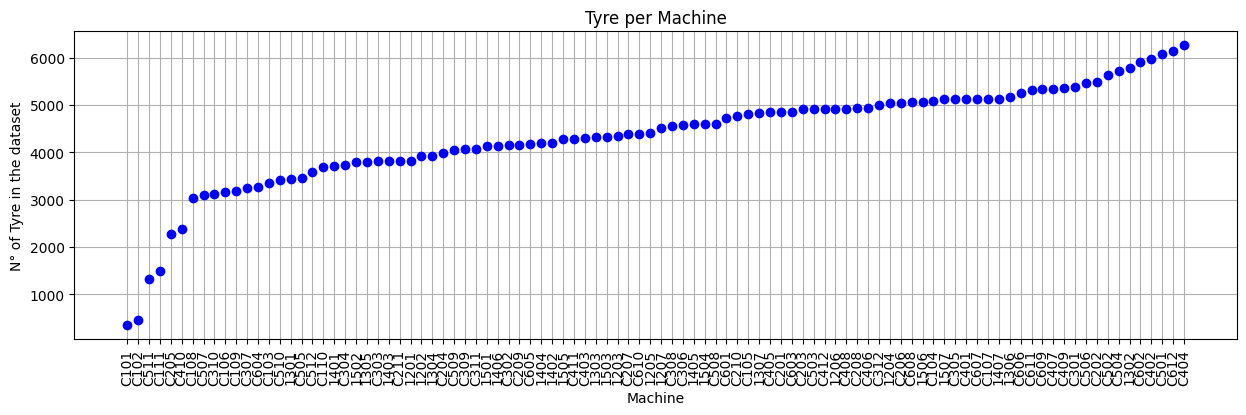

In [56]:
x = tyre_per_machine[ColumnsInput.machine]
y = tyre_per_machine[ColumnsInput.barcode]

general_plot(x, y, title = "Tyre per Machine", x_title = "Machine", y_title = "N° of Tyre in the dataset")

In [57]:
tyre_per_arm = df.groupby([ColumnsInput.machine,ColumnsInput.machine_side])[ColumnsInput.barcode].nunique().reset_index()
tyre_per_arm = tyre_per_arm.sort_values(by = ColumnsInput.barcode ).reset_index()
tyre_per_arm

,index,ddc_mch_code,ddc_mch_side,ddc_barcode
0,57,C101,R,160
1,56,C101,L,184
2,59,C102,R,221
3,58,C102,L,227
4,168,C511,L,535
5,77,C111,R,690
6,169,C511,R,790
7,76,C111,L,792
8,87,C205,R,1109
9,142,C410,L,1150


In [58]:
#

In [59]:
tyre_per_arm = df.groupby([ColumnsInput.machine,ColumnsInput.machine_side])[ColumnsInput.barcode].nunique()
mean = tyre_per_arm.mean()
var = tyre_per_arm.std()
print("Mean = ", mean, " Var = ", var)

Mean =  2172.862244897959  Var =  564.3690158525907


#### Number of barcodes per Old and New Presses average

In [60]:
#New one should have higher production
df_by_machine = df.groupby([ColumnsInput.machine])[ColumnsInput.barcode].nunique().reset_index()
col_c_machine = 'c_machine'
df_by_machine[col_c_machine] = df_by_machine[ColumnsInput.machine].str.startswith('C')
df_by_machine.groupby(col_c_machine)[ColumnsInput.barcode].mean()

c_machine
False    4403.464286
True     4322.614286
Name: ddc_barcode, dtype: float64

#### Press time analysis
Understanding different time patterns and distributions in the machines or between events

In [24]:
df_min_max_time = df.groupby([ColumnsInput.machine,ColumnsOutput.c_machine,ColumnsInput.barcode])[ColumnsInput.time].agg(['min','max']).reset_index()
col_delta_time = 'delta_time'
df_min_max_time[col_delta_time] = (df_min_max_time['max'] - df_min_max_time['min']).dt.total_seconds()
df_min_max_time

,ddc_mch_code,c_machine,ddc_barcode,min,max,delta_time
0,1201,False,9439573480,2022-10-10 14:51:36,2022-10-10 15:14:38,1382.0
1,1201,False,9439573569,2022-10-11 05:26:56,2022-10-11 05:49:44,1368.0
2,1201,False,9439573631,2022-10-10 00:24:10,2022-10-10 00:50:03,1553.0
3,1201,False,9439573633,2022-10-10 01:16:09,2022-10-10 01:41:58,1549.0
4,1201,False,9439573635,2022-10-10 01:41:58,2022-10-10 02:07:32,1534.0
5,1201,False,9439573636,2022-10-10 00:50:03,2022-10-10 01:16:09,1566.0
6,1201,False,9439573639,2022-10-10 00:00:04,2022-10-10 00:24:10,1446.0
7,1201,False,9439573642,2022-10-10 02:58:36,2022-10-10 03:23:52,1516.0
8,1201,False,9439573644,2022-10-10 03:23:52,2022-10-10 03:49:21,1529.0
9,1201,False,9439573645,2022-10-10 02:07:33,2022-10-10 02:33:11,1538.0


#### Description of the distribution of the time required for the old and new presses to produce a tyre

In [25]:
df_min_max_time[col_delta_time].describe()

count    425880.000000
mean       1631.067132
std        4988.959642
min           0.000000
25%        1052.000000
50%        1095.000000
75%        1182.000000
max       87208.000000
Name: delta_time, dtype: float64

#### Understanding which are the fist and last events of a barcode to check amount of time between them

In [26]:
df.sort_values(ColumnsInput.time).groupby(ColumnsInput.barcode)[ColumnsInput.event].agg(['first','last']).value_counts()

first                         last                      
LO_LOADER_IN_PRESS_START      UN_FORK_OUT_STOP              196656
                              UN_UNLOADER_OUT_STOP          130266
                              UN_TCR_DOWN_STOP               87547
                              UN_VACUUM_STOP                  1418
                              UN_TCR_UP_LMR_DOWN_START        1051
                              UN_TCR_UP_LMR_DOWN_STOP          493
UN_VACUUM_STOP                UN_FORK_OUT_STOP                 432
LO_LOADER_IN_PRESS_START      UN_FORK_OUT_START                396
OP_PRESS_MOVEMENT_UP_1_START  UN_FORK_OUT_STOP                 380
CURING_OFF_START              UN_FORK_OUT_STOP                 378
UN_VACUUM_START               UN_FORK_OUT_STOP                 362
OP_PRESS_STOP_PAUSE_3_START   UN_FORK_OUT_STOP                 323
OP_PRESS_MOVEMENT_UP_1_STOP   UN_FORK_OUT_STOP                 322
CURING_OFF_STOP               UN_FORK_OUT_STOP                 307
OP_PR

Avarage working time for an entire cycle process by the two types of machines.

In [28]:
mean = df_min_max_time.groupby(ColumnsOutput.c_machine)[col_delta_time].mean()
var = df_min_max_time.groupby(ColumnsOutput.c_machine)[col_delta_time].std()
print("Cycle time new machine = ", mean[1], " +- ", var[1])

Cycle time new machine =  1748.4590343806492  +-  5789.839403434247


In [29]:
df_min_max_time_per_machine_mean = df_min_max_time.groupby([ColumnsInput.machine])[col_delta_time].mean()
df_min_max_time_per_machine_var = df_min_max_time.groupby(ColumnsInput.machine)[col_delta_time].std()
df_min_max_time_per_machine_mean = df_min_max_time_per_machine_mean.sort_values().reset_index()
df_min_max_time_per_machine_mean

,ddc_mch_code,delta_time
0,1407,1062.356196
1,C101,1091.726744
2,C608,1091.980040
3,C612,1103.732009
4,1302,1114.152727
5,1306,1130.792957
6,C602,1152.268214
7,C611,1154.943974
8,C601,1164.378865
9,1405,1180.413816


#### Distribution of the time an entire cycle to be conclude

In [30]:
df_min_max_time_per_machine_mean.describe()

,delta_time
count,98.000000
mean,1649.062330
std,429.557798
min,1062.356196
25%,1283.888940
50%,1588.476795
75%,1935.096594
max,2884.256152


##### Plot the average cycle time per machine to visualize which are the performance of each machine and che possible outliers

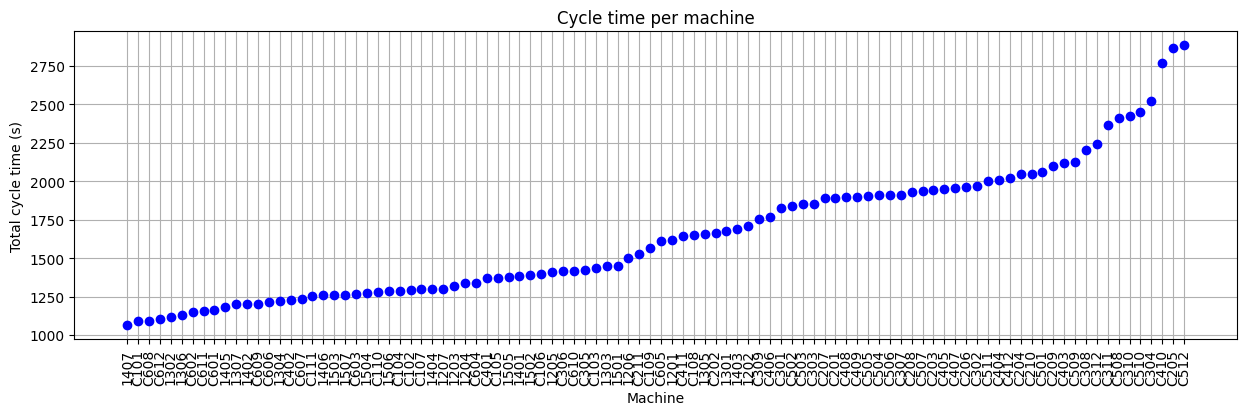

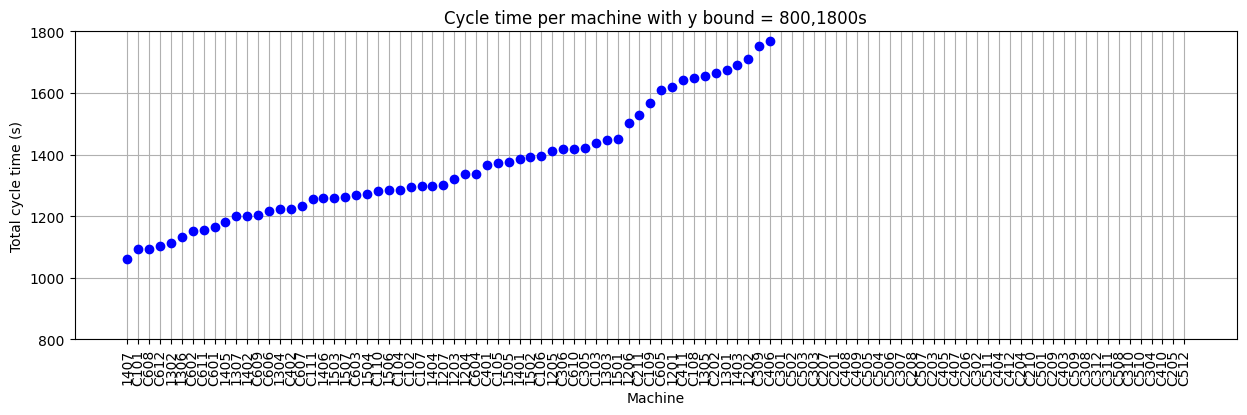

In [31]:
x = df_min_max_time_per_machine_mean[ColumnsInput.machine]
y = df_min_max_time_per_machine_mean[col_delta_time]
general_plot(x, y, title = "Cycle time per machine", x_title = "Machine", y_title = "Total cycle time (s)")
general_plot(x, y, y_bounds = [800,1800], title = "Cycle time per machine with y bound = 800,1800s", x_title = "Machine", y_title = "Total cycle time (s)")

In [61]:
df_time_per_event = df.groupby([ColumnsInput.barcode,ColumnsInput.time, ColumnsInput.event])[ColumnsInput.event].count()##### Analysing how much time require each process

In [32]:
df_time_per_event = df.groupby([ColumnsInput.ipcode, ColumnsInput.event])[ColumnsInput.time].agg('min').sort_values().reset_index()
df_time_per_event

,ddc_ipcode,ddc_ev_subcode,ddc_ev_timestamp
0,27637,CURING_OFF_START,2022-10-10 00:00:00
1,39336,OP_PRESS_STOP_PAUSE_3_START,2022-10-10 00:00:00
2,39332,UN_FORK_OUT_START,2022-10-10 00:00:00
3,24453,OP_PRESS_STOP_PAUSE_3_STOP,2022-10-10 00:00:00
4,24453,OP_PRESS_STOP_PAUSE_3_START,2022-10-10 00:00:00
5,39659,CURING_OFF_START,2022-10-10 00:00:00
6,18825,UN_VACUUM_STOP,2022-10-10 00:00:00
7,18825,OP_PRESS_STOP_PAUSE_3_STOP,2022-10-10 00:00:00
8,41596,LO_LOADER_DOWN_START,2022-10-10 00:00:00
9,24453,CURING_OFF_STOP,2022-10-10 00:00:00


Here is possible to check how much time took each process to be completed


In [33]:

event_delta_time = 'event_delta_time'
df_time_per_event[event_delta_time] = df_time_per_event[ColumnsInput.time].diff().dt.total_seconds()
df_time_per_event
#df_time_per_event[event_delta_time] = df_time_per_event[ColumnsInput.time].diff().fillna(timedelta(0)).apply(lambda x: x.total_seconds())
#df_time_per_event[event_delta_time] = df_time_per_event[ColumnsInput.time].diff()

,ddc_ipcode,ddc_ev_subcode,ddc_ev_timestamp,event_delta_time
0,27637,CURING_OFF_START,2022-10-10 00:00:00,NaN
1,39336,OP_PRESS_STOP_PAUSE_3_START,2022-10-10 00:00:00,0.0
2,39332,UN_FORK_OUT_START,2022-10-10 00:00:00,0.0
3,24453,OP_PRESS_STOP_PAUSE_3_STOP,2022-10-10 00:00:00,0.0
4,24453,OP_PRESS_STOP_PAUSE_3_START,2022-10-10 00:00:00,0.0
5,39659,CURING_OFF_START,2022-10-10 00:00:00,0.0
6,18825,UN_VACUUM_STOP,2022-10-10 00:00:00,0.0
7,18825,OP_PRESS_STOP_PAUSE_3_STOP,2022-10-10 00:00:00,0.0
8,41596,LO_LOADER_DOWN_START,2022-10-10 00:00:00,0.0
9,24453,CURING_OFF_STOP,2022-10-10 00:00:00,0.0


In [34]:
df_time_per_event[event_delta_time].describe()

count     15450.000000
mean        399.371650
std        9629.131992
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max      785149.000000
Name: event_delta_time, dtype: float64

In [35]:
df_time_per_event_mean = df_time_per_event.groupby([ColumnsInput.event])[event_delta_time].mean().reset_index()
df_time_per_event_mean = df_time_per_event_mean.sort_values(by = event_delta_time).reset_index()
df_time_per_event_mean

,index,ddc_ev_subcode,event_delta_time
0,79,UN_TCR_UP_NO_SUV_STOP,0.220588
1,7,CL_PRESS_LOCK_STOP,0.425234
2,65,UN_LMR_TCR_VACUUM_STOP,0.431579
3,86,UN_UNLOADER_UP_START,0.484211
4,69,UN_OPEN_ARMS_STOP,0.515789
5,46,OP_PRESS_MOVEMENT_UP_START,0.621495
6,78,UN_TCR_UP_NO_SUV_START,0.647059
7,57,OP_UNLOCK_PRESS_STOP,0.686916
8,68,UN_OPEN_ARMS_START,0.747368
9,1,CL_PRESS_DOWN_2_STOP,0.780374


In [36]:
df_time_per_event_mean.describe()

,index,event_delta_time
count,90.000000,90.000000
mean,44.500000,407.378241
std,26.124701,1529.085699
min,0.000000,0.220588
25%,22.250000,1.216121
50%,44.500000,2.443925
75%,66.750000,39.633762
max,89.000000,10436.626168


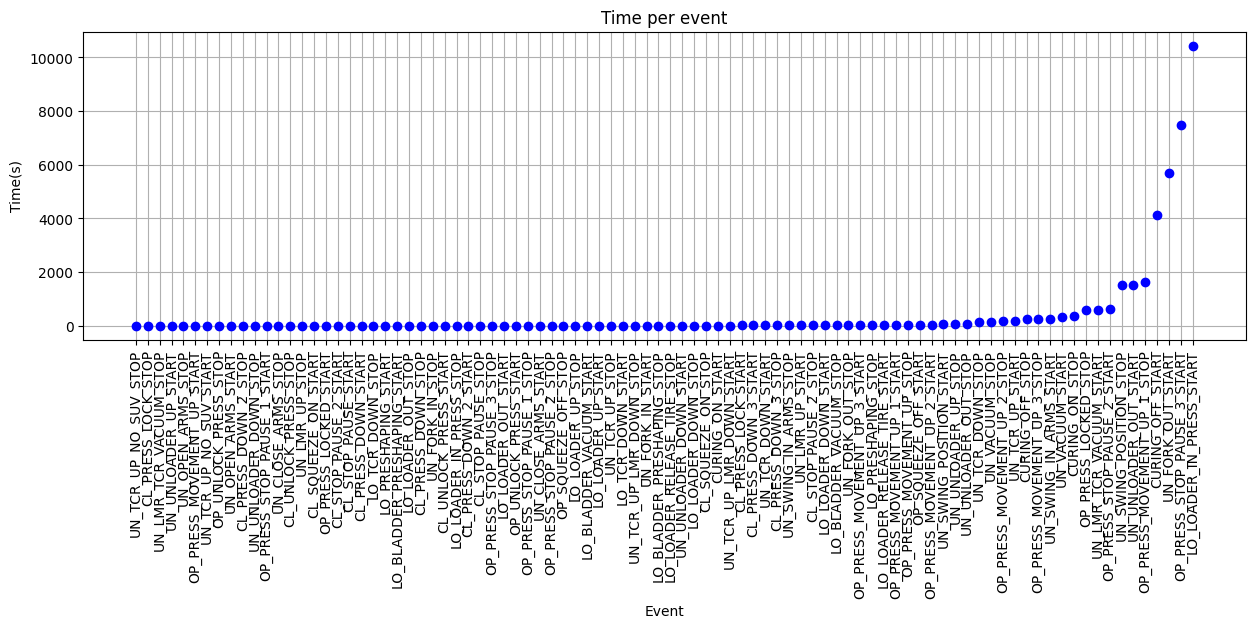

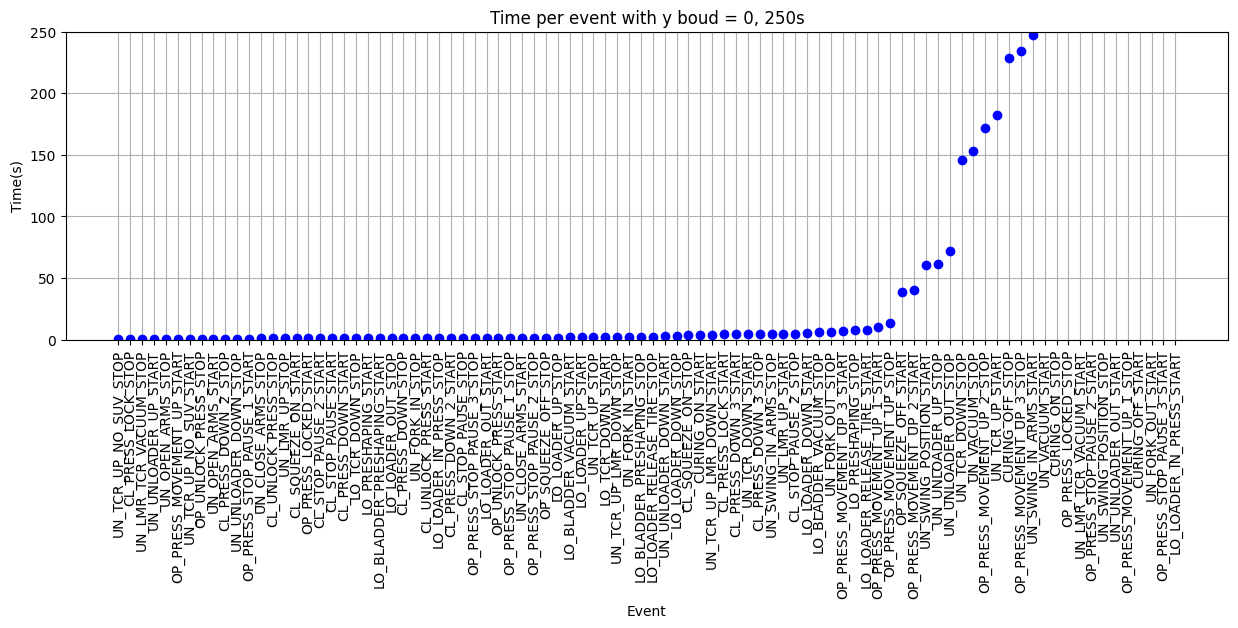

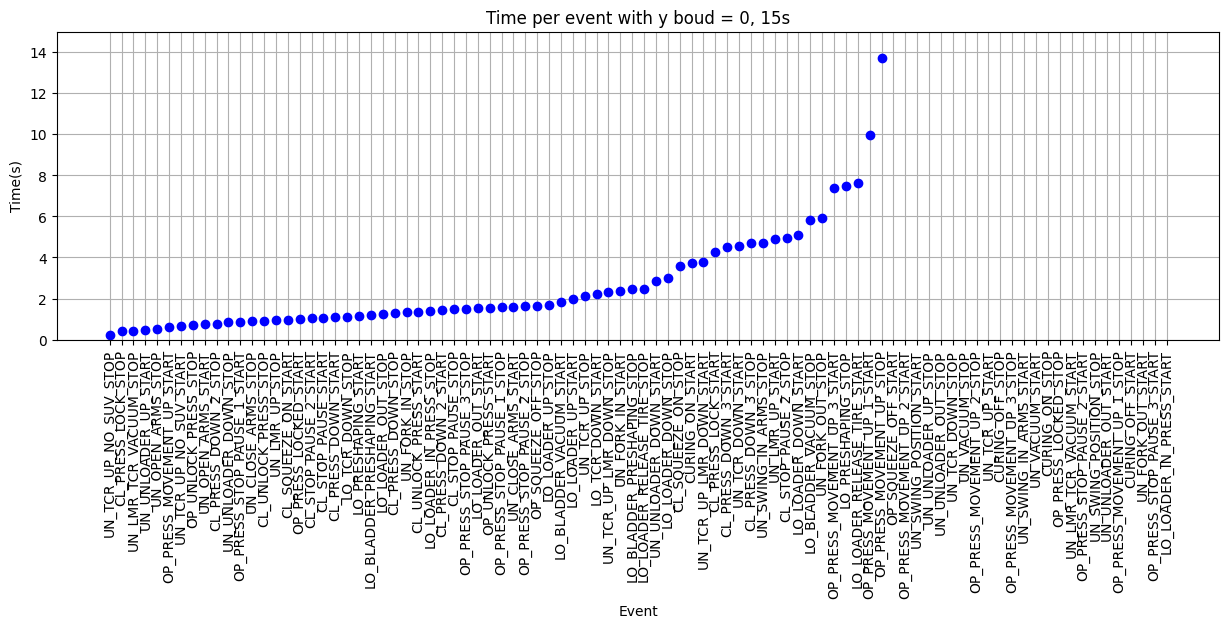

In [37]:
x = df_time_per_event_mean[ColumnsInput.event]
y = df_time_per_event_mean[event_delta_time]

general_plot(x,y, title = "Time per event", x_title = "Event", y_title = "Time(s)")

y_bounds = [0,250]
general_plot(x,y, y_bounds = y_bounds,  title = "Time per event with y boud = 0, 250s", x_title = "Event", y_title = "Time(s)")

y_bounds = [0,15]
general_plot(x,y, y_bounds = y_bounds,  title = "Time per event with y boud = 0, 15s", x_title = "Event", y_title = "Time(s)")